## Example3.2: 1000 Cell Microcircuit Simulation

Loading datasets ...

 Plotting cell bodies ...

 Plotting spiking activity ...


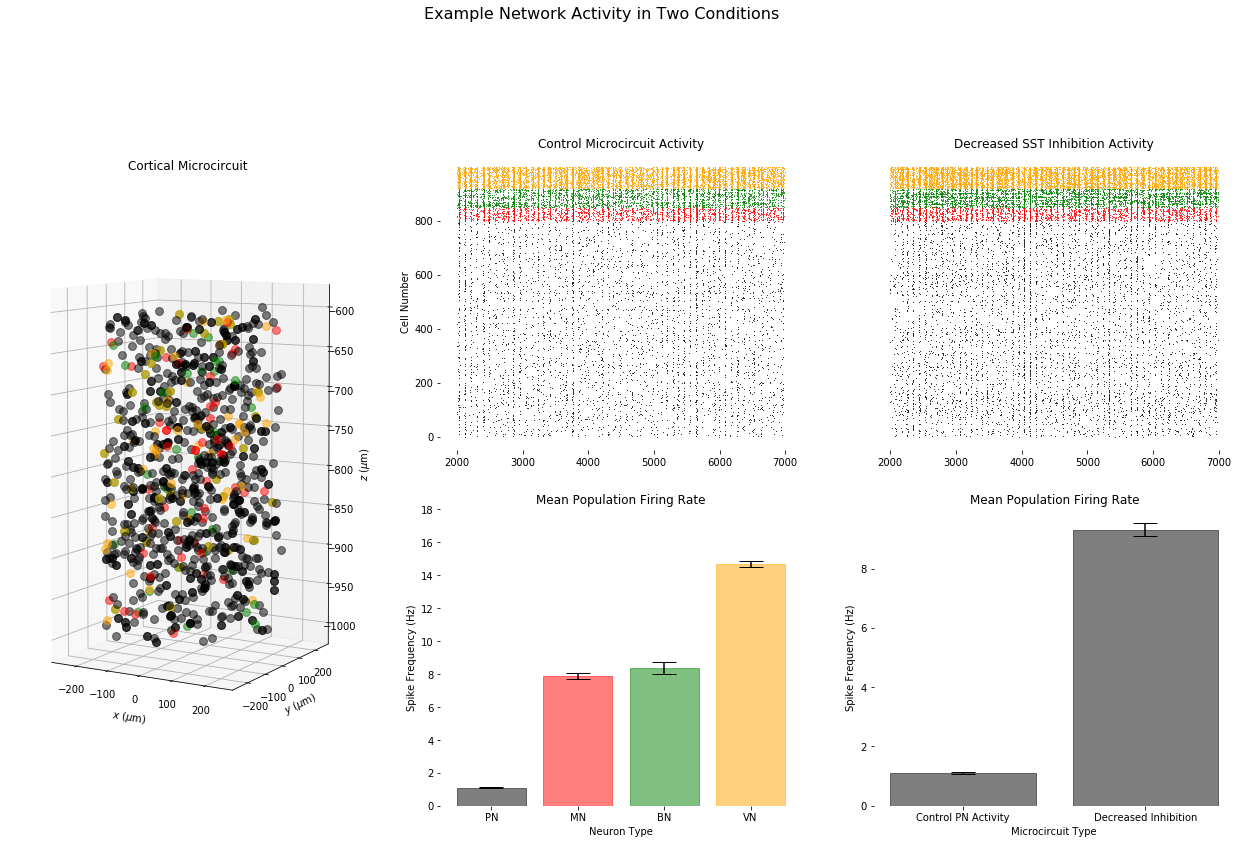

In [174]:
####################################################################
# Import Modules and load relevant files
####################################################################
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *
import h5py

####################################################################
# Simulation Details
####################################################################

'''
1000 total cells:
    800 Pyramidal Neurons
    50 SST/Martinotti Interneurons
    70 Basket Interneurons
    80 VIP Interneurons
    
7000 ms (2000ms transient, 5000ms simulation)

LFP: 3 electrodes: -400um, -800um, -1000um
ECoG: 1 electrode at pial surface: 0um
EEG: 1 electrode at scalp surface: 10000um

************** PSD OVERLAP FOR CONTROL AND DECREASED SST
show rates side by side in one plot 
control timeseries, PSD overlap, decreased timeseries

Run 1: Healthy Circuit
Run 2: Decreased SST Inhibition (50% reduction)

Output:
    SPIKES: Neuron spike time
    OUTPUT: LFP controbution for each population
    DIPOLEMOMENT: x,y,z-components of current-dipole moment from 
                  transmembrane currents summed up over all populations

'''
print('Loading datasets ...')
SPIKES_1 = np.load('Circuit_output/SPIKES_1.npy', allow_pickle=True)
OUTPUT_1 = np.load('Circuit_output/OUTPUT_1.npy')
DIPOLEMOMENT_1 = np.load('Circuit_output/DIPOLEMOMENT_1.npy')


SPIKES_2 = np.load('Circuit_output/SPIKES_2.npy', allow_pickle=True)
OUTPUT_2 = np.load('Circuit_output/OUTPUT_2.npy')
DIPOLEMOMENT_2 = np.load('Circuit_output/DIPOLEMOMENT_2.npy')

####################################################################
# Plotting
####################################################################
###################################
# Population Cell Bodies
###################################
print('\n','Plotting cell bodies ...')
popnames = ['HL23PN1', 'HL23MN1', 'HL23BN1', 'HL23VN1']
clrs = {'HL23PN1':'k',
        'HL23MN1':'red',
        'HL23BN1':'green',
        'HL23VN1':'orange'}
filename = "Circuit_output/3_2_cell_positions_and_rotations.h5"
tvec = np.arange(7000 / 0.0625 + 1) * 0.0625

fig = plt.figure(figsize=([22, 12]))
ax = fig.add_subplot(131, projection='3d')
ax.view_init(elev=5)
for name in popnames:
    with h5py.File(filename, "r") as f:
        for i in range(len(f[name])):
            ax.scatter(f[name][i][1], f[name][i][2], f[name][i][3],c=clrs[name], marker='.', s=250, alpha=.5)
    ax.set_xlabel('$x$ ($\mu$m)')
    ax.set_ylabel('$y$ ($\mu$m)')
    ax.set_zlabel('$z$ ($\mu$m)')
    ax.zaxis.labelpad=15
    ax.set_title('Cortical Microcircuit', y=1.05)


###################################
# Raster Plots
###################################
print('\n','Plotting spiking activity ...')
SPIKES = [SPIKES_1, SPIKES_2]
subplot = [232,233]
title = ['Control Microcircuit Activity', 'Decreased SST Inhibition Activity']
ylabel = ['Cell Number', '']
yticks = [np.arange(0, 1000, 200), []]

for i, run in enumerate(SPIKES):
    ax = fig.add_subplot(subplot[i], frameon=False)
    for color, name, spts, gids in zip(clrs, popnames, run.item(0)['times'], run.item(0)['gids']):
        t = []
        g = []
        for spt, gid in zip(spts, gids):
            t = np.r_[t, spt]
            g = np.r_[g, np.zeros(spt.size)+gid]
        ax.plot(t[t >= 2000], g[t >= 2000], '|', color=clrs[name], markersize=.8)
    ax.set_ylabel(ylabel[i])
    ax.set_yticks(yticks[i])
    ax.set_title(title[i])


###################################
# Spike Rates
###################################
SPIKES = [SPIKES_1]
subplot = [235,236]
ylabel = ['Spike Frequency (Hz)', '']

yticks = [np.arange(0, 20, 2)]


for a,run in enumerate(SPIKES):
    PN_Hz = []
    for i in range(len(run.item(0)['times'][0])):
        Hz = (run.item(0)['times'][0][i].size)/(7)
        PN_Hz.append(Hz)

    MN_Hz = []
    for i in range(len(run.item(0)['times'][1])):
        Hz = (run.item(0)['times'][1][i].size)/(7)
        MN_Hz.append(Hz)

    BN_Hz = []
    for i in range(len(run.item(0)['times'][2])):
        Hz = (run.item(0)['times'][2][i].size)/(7)
        BN_Hz.append(Hz)

    VN_Hz = []
    for i in range(len(run.item(0)['times'][3])):
        Hz = (run.item(0)['times'][3][i].size)/(7)
        VN_Hz.append(Hz)

    w = 0.8
    x = [0, 1, 2, 3]

    Hzs = [PN_Hz, MN_Hz, BN_Hz, VN_Hz]
    names = ['PN', 'MN', 'BN', 'VN']
    colors = ['black', 'red', 'green','orange']
    secondx=[]
    for i, j in enumerate(Hzs):
        length = np.ones(len(j))*i
        secondx.append(length)

    ax = fig.add_subplot(subplot[a], frameon=False)

    ax.bar(x,height=[np.mean(cell) for cell in Hzs],
           yerr=[st.sem(cell) for cell in Hzs],
           capsize=12,
           width=w,
           tick_label=names,
           color=[clr for clr in colors],
           edgecolor=[clr for clr in colors],
           ecolor='black',
           alpha=0.5)

#     for i in range(4):
#         ax.scatter(secondx[i]+.5* w - w / 2, Hzs[i], color=colors[i])
    ax.set_ylabel(ylabel[a])
    ax.set_yticks(yticks[a])
    ax.set_xlabel('Neuron Type')
    ax.set_title('Mean Population Firing Rate')
    ax.grid(False)


PN_1_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][0])):
    Hz = (SPIKES_1.item(0)['times'][0][i].size)/(7)
    PN_1_Hz.append(Hz)

PN_2_Hz = []
for i in range(len(SPIKES_2.item(0)['times'][1])):
    Hz = (SPIKES_2.item(0)['times'][1][i].size)/(7)
    PN_2_Hz.append(Hz)


w = 0.8
x = [0, 1]

Hzs = [PN_Hz, PN_2_Hz]
names = ['Control PN Activity', 'Decreased Inhibition']
colors = ['black', 'black']
secondx=[]
for i, j in enumerate(Hzs):
    length = np.ones(len(j))*i
    secondx.append(length)

ax = fig.add_subplot(236, frameon=False)

ax.bar(x,height=[np.mean(cell) for cell in Hzs],
       yerr=[st.sem(cell) for cell in Hzs],
       capsize=12,
       width=w,
       tick_label=names,
       color=[clr for clr in colors],
       edgecolor=[clr for clr in colors],
       ecolor='black',
       alpha=0.5)

ax.set_ylabel('Spike Frequency (Hz)')
ax.set_xlabel('Microcircuit Type')
ax.set_title('Mean Population Firing Rate')
ax.grid(False)
plt.suptitle('Example Network Activity in Two Conditions', y=1.05, fontsize=16)

plt.show()

In [ ]:
- have 4 in control, just compare PN on right 
- run each 5 times should be enough

In [2]:

DIPOLEMOMENTS = [DIPOLEMOMENT_1, DIPOLEMOMENT_2]
names = ['HL23PN1', 'HL23MN1', 'HL23BN1', 'HL23VN1']
fig = plt.figure(figsize=(20,20))
xrange = [0, 100]
def bandPassFilter(signal):
    fs = 16000
    highcut = 1/0.0625

    nyq = 0.5*fs
    high = highcut/nyq

    order = 2

    b, a = ss.butter(order, high, analog=False)
    y = ss.filtfilt(b, a, signal, axis=0)

    return(y)

EEGs = {}
ECoGs = {}

for i, run in enumerate(DIPOLEMOMENTS):
    radii = [79000., 80000., 85000., 90000.]
    sigmas = [0.3, 1.5, 0.015, 0.3]
    r1 = np.array([[0., 0., 79000]])
    r2 = np.array([[0., 0., 90000]])

    rz = np.array([0., 0., 78200.])
    sphere_model1 = LFPy.FourSphereVolumeConductor(radii, sigmas, r1)
    sphere_model2 = LFPy.FourSphereVolumeConductor(radii, sigmas, r2)
#     for name in names:
#         ECoG = sphere_model1.calc_potential(run[name], rz)
#         ECoG2 = np.reshape(ECoG, (112001))
#         ECoGs.update({name:ECoG2})
        
#         EEG = sphere_model2.calc_potential(run[name], rz)
#         EEG2 = np.reshape(EEG, (112001))
#         EEGs.update({name:EEG2})


    rawEEG = EEG2
    rawECoG = ECoG2
    filteredEEG = bandPassFilter(EEG2)
    filteredECoG = bandPassFilter(ECoG2)

    raw = [rawEEG, rawECoG]
    filtered = [filteredEEG, filteredECoG]
    names = ['EEG', 'ECoG']

    tvec = np.arange(7000/0.0625+1)*0.0625
    t1 = int(2000/0.0625)

    fs = 16000

    freqrawEEG, psrawEEG = ss.welch(rawEEG[t1:], fs*0.0625)
    freqrawECoG, psrawECoG = ss.welch(rawECoG[t1:], fs*0.0625)
    freqfilteredEEG, psfilteredEEG, = ss.welch(filteredEEG[t1:], fs*0.0625)
    freqfilteredECoG, psfilteredECoG = ss.welch(filteredECoG[t1:], fs*0.0625)


    rawpsd = [psrawEEG, psrawECoG]
    rawfreq = [freqrawEEG, freqrawECoG]
    filteredpsd = [psfilteredEEG, psfilteredECoG]
    filteredfreq = [freqfilteredEEG, freqfilteredECoG]
    names2 = ['psd EEG', 'psd ECoG']

    if i==0:
        subplots = [(0, 0), (1, 0)]
        title = ['Control: EEG', 'ECOG']
    if i==1:
        subplots = [(0, 2), (1, 2)]
        title = ['Decreased Inhibition: EEG', 'ECOG']
    plt.subplot2grid((5, 3), subplots[0], rowspan=1, colspan=1)
    plt.plot(tvec[t1:], rawEEG[t1:], c='k', alpha=0.5)
    plt.plot(tvec[t1:], filteredEEG[t1:], c='k')
    plt.title(title[0])

#     plt.subplot(5, 2, 2)
#     plt.plot(freqrawEEG, psrawEEG, c='k', alpha=0.5)
#     plt.plot(freqfilteredEEG, psfilteredEEG,  c='k')
#     plt.title('EEG PSD')
#     plt.xlim(xrange)

    plt.subplot2grid((5, 3), subplots[1], rowspan=1, colspan=1)
    plt.plot(tvec[t1:], rawECoG[t1:], c='k', alpha=0.5)
    plt.plot(tvec[t1:], filteredECoG[t1:], c='k')
    plt.title(title[1])

#     plt.subplot(5, 2, 4)
#     plt.plot(freqrawECoG, psrawECoG, c='k', alpha=0.5)
#     plt.plot(freqfilteredECoG,psfilteredECoG, c='k')
#     plt.title('ECoG PSD')
    plt.xlim(xrange)


#     max_y = max(psrawEEG)  # Find the maximum y value
#     max_x = freqrawEEG[psrawEEG.argmax()]  # Find the x value corresponding to the maximum y value
#     print('EEG peak: ',max_x,max_y)

#     max_y = max(psrawECoG)  # Find the maximum y value
#     max_x = freqrawECoG[psrawECoG.argmax()]  # Find the x value corresponding to the maximum y value
#     print('ECoG peak: ',max_x,max_y)

OUTPUTS = [OUTPUT_1, OUTPUT_2]
for i, OUTPUT in enumerate(OUTPUTS):
    rawsupLFP = OUTPUT[0]['imem'][0]
    rawmidLFP = OUTPUT[0]['imem'][1]
    rawdeepLFP = OUTPUT[0]['imem'][2]

    filteredsupLFP = bandPassFilter(OUTPUT[0]['imem'][0])
    filteredmidLFP = bandPassFilter(OUTPUT[0]['imem'][1])
    filtereddeepLFP = bandPassFilter(OUTPUT[0]['imem'][2])
    
    raw = [rawsupLFP, rawmidLFP, rawdeepLFP]
    filtered = [filteredsupLFP, filteredmidLFP, filtereddeepLFP]
    names = ['supLFP', 'midLFP', 'rawdeepLFP']


    freqrawsupLFP, psrawsupLFP = ss.welch(rawsupLFP[t1:], fs*0.0625)
    freqrawmidLFP, psrawmidLFP = ss.welch(rawmidLFP[t1:], fs*0.0625)
    freqrawdeepLFP, psrawdeepLFP = ss.welch(rawdeepLFP[t1:], fs*0.0625)

    freqfilteredsupLFP, psfilteredsupLFP = ss.welch(filteredsupLFP[t1:], fs*0.0625)
    freqfilteredmidLFP, psfilteredmidLFP = ss.welch(filteredmidLFP[t1:], fs*0.0625)
    freqfiltereddeepLFP, psfiltereddeepLFP = ss.welch(filtereddeepLFP[t1:], fs*0.0625)


    rawpsd = [psrawsupLFP, psrawmidLFP, psrawdeepLFP]
    rawfreq = [freqrawsupLFP, freqrawmidLFP, freqrawdeepLFP]

    filteredpsd = [psfilteredsupLFP, psfilteredmidLFP, psfiltereddeepLFP]
    filteredfreq = [freqfilteredsupLFP, freqfilteredmidLFP, freqfiltereddeepLFP]
    names2 = ['psd supLFP', 'psd rawmidLFP', 'psd rawdeepLFP']

    if i==0:
        subplots = [(2,0), (3, 0), (4, 0)]
        title = ['Superficial LFP', 'Midpoint LFP', 'Deep LFP']
    if i==1:
        subplots = [(2,2), (3, 2), (4, 2)]
        title = ['Superficial LFP', 'Midpoint LFP', 'Deep LFP']
    ax = plt.subplot2grid((5, 3), subplots[0], rowspan=1, colspan=1)
    ax.plot(tvec[t1:], rawsupLFP[t1:], c='k', alpha=0.5)
    ax.plot(tvec[t1:], filteredsupLFP[t1:], c='k')
    ax.set_title(title[0])

#     plt.subplot(5, 2, 6)
#     plt.plot(freqrawsupLFP, psrawsupLFP, c='k', alpha=0.5)
#     plt.plot(freqfilteredsupLFP, psfilteredsupLFP, c='k')
#     plt.title('LFPsup PSD')
#     plt.xlim(xrange)

    ax = plt.subplot2grid((5, 3), subplots[1], rowspan=1, colspan=1)
    ax.plot(tvec[t1:], rawsupLFP[t1:], c='k', alpha=0.5)
    ax.plot(tvec[t1:], filteredsupLFP[t1:], c='k')
    ax.set_title(title[0])

#     plt.subplot(5, 2, 8)
#     plt.plot(freqrawmidLFP,psrawmidLFP, c='k', alpha=0.5)
#     plt.plot(freqfilteredmidLFP, psfilteredmidLFP, c='k')
#     plt.title('LFPmid PSD')
#     plt.xlim(xrange)

    plt.subplot2grid((5, 3), subplots[2], rowspan=1, colspan=1)
    plt.plot(tvec[t1:], rawdeepLFP[t1:], c='k', alpha=0.5)
    plt.plot(tvec[t1:], filtereddeepLFP[t1:], c='k')
    plt.title(title[2])

#     plt.subplot(5, 2, 10)
#     plt.plot(freqrawdeepLFP,psrawdeepLFP, c='k', alpha=0.5)
#     plt.plot(freqfiltereddeepLFP, psfiltereddeepLFP, c='k')
#     plt.title('LFPdeep PSD')
    plt.xlim(xrange)
   
#     max_y = max(psrawsupLFP)  # Find the maximum y value
#     max_x = freqrawsupLFP[psrawsupLFP.argmax()]  # Find the x value corresponding to the maximum y value
#     print('LFPsup peak: ',max_x,max_y)

#     max_y = max(psrawmidLFP)  # Find the maximum y value
#     max_x = freqrawmidLFP[psrawmidLFP.argmax()]  # Find the x value corresponding to the maximum y value
#     print('LFPmid peak: ',max_x,max_y)

#     max_y = max(psrawdeepLFP)  # Find the maximum y value
#     max_x = freqrawdeepLFP[psrawdeepLFP.argmax()]  # Find the x value corresponding to the maximum y value
#     print('LFPdeep peak: ',max_x,max_y)
plt.tight_layout

Loading datasets ...


NameError: name 'EEG2' is not defined

<Figure size 1440x1440 with 0 Axes>

done


<Figure size 1440x1296 with 0 Axes>

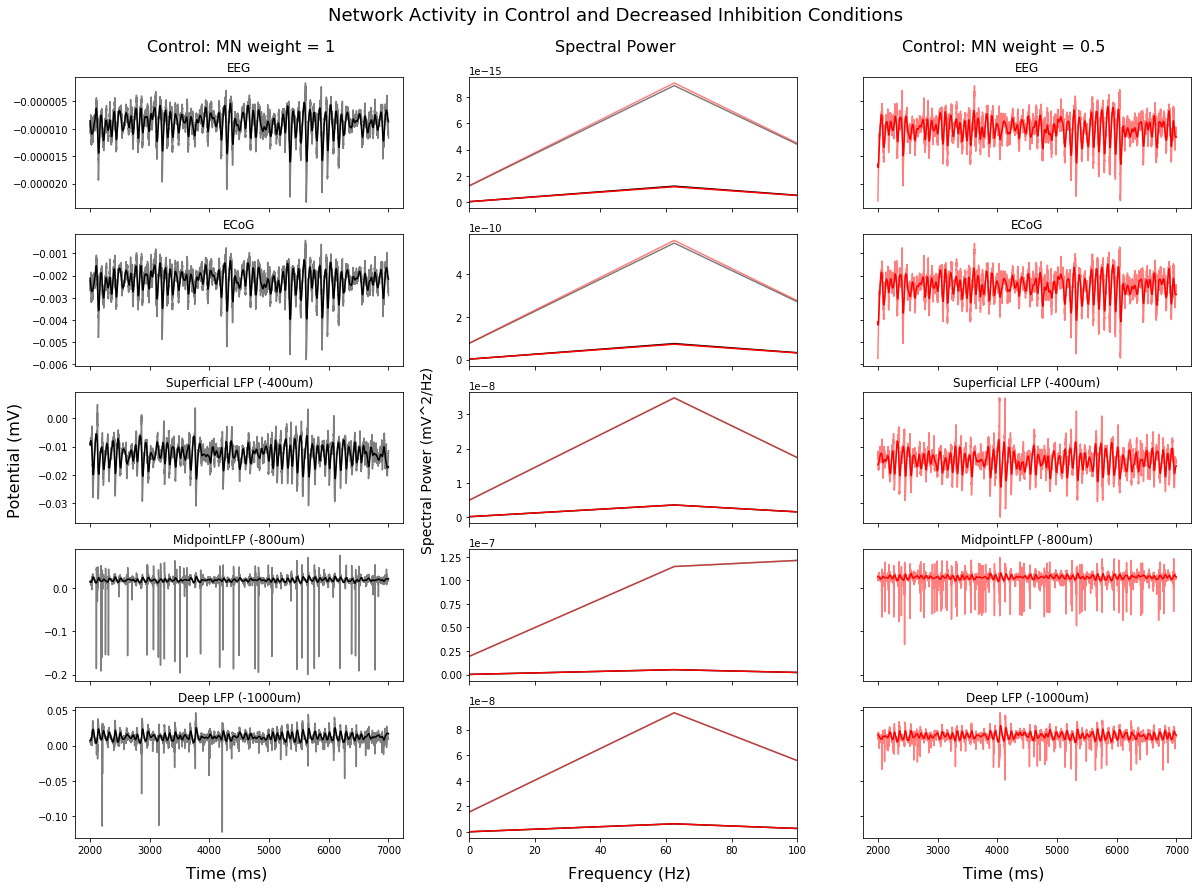

In [198]:
# import os
# from os.path import join
# import sys
# import zipfile
# import matplotlib
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.collections import LineCollection
# from matplotlib.collections import PolyCollection
# import numpy as np
# np.seterr(divide='ignore', invalid='ignore')
# import scipy
# from scipy import signal as ss
# from scipy import stats as st
# from mpi4py import MPI
# import math
# import neuron
# from neuron import h, gui
# import LFPy
# from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
# from net_params import *
# import h5py


# print('Loading datasets ...')
# SPIKES_1 = np.load('Circuit_output/SPIKES_1.npy', allow_pickle=True)
# OUTPUT_1 = np.load('Circuit_output/OUTPUT_1.npy')
# DIPOLEMOMENT_1 = np.load('Circuit_output/DIPOLEMOMENT_1.npy')


# SPIKES_2 = np.load('Circuit_output/SPIKES_2.npy', allow_pickle=True)
# OUTPUT_2 = np.load('Circuit_output/OUTPUT_2.npy')
# DIPOLEMOMENT_2 = np.load('Circuit_output/DIPOLEMOMENT_2.npy')

# DIPOLEMOMENTS = [DIPOLEMOMENT_1, DIPOLEMOMENT_2]
# OUTPUTS = [OUTPUT_1, OUTPUT_2]

names = ['HL23PN1', 'HL23MN1', 'HL23BN1', 'HL23VN1']
fig = plt.figure(figsize=(20,18))
xrange = [0, 100]
tvec = np.arange(7000/0.0625+1)*0.0625
t1 = int(2000/0.0625)

fs = 16000

def bandPassFilter(signal):
    fs = 16000
    highcut = 1/0.0625

    nyq = 0.5*fs
    high = highcut/nyq

    order = 2

    b, a = ss.butter(order, high, analog=False)
    y = ss.filtfilt(b, a, signal, axis=0)

    return(y)

ECoGs = {}
EEGs = {}
for i, DIPOLEMOMENT in enumerate(DIPOLEMOMENTS):
    radii = [79000., 80000., 85000., 90000.]
    sigmas = [0.3, 1.5, 0.015, 0.3]
    rz = np.array([0., 0., 78400.])
    r1 = np.array([[0., 0., 79000]])
    r2 = np.array([[0., 0., 90000]])
    
    
    sphere_model1 = LFPy.FourSphereVolumeConductor(radii, sigmas, r1)
    sphere_model2 = LFPy.FourSphereVolumeConductor(radii, sigmas, r2)
    
    for name in names:
        ECoG = sphere_model1.calc_potential(DIPOLEMOMENT[name], rz)
        ECoG2 = np.reshape(ECoG, (112001))
        ECoGs[str('DP_'+str(i+1)+name)] = ECoG2

        EEG = sphere_model2.calc_potential(DIPOLEMOMENT[name], rz)
        EEG2 = np.reshape(EEG, (112001))
        EEGs[str('DP_'+str(i+1)+name)] = EEG2

a = np.add(ECoGs['DP_1HL23PN1'],ECoGs['DP_1HL23MN1'])
b = np.add(ECoGs['DP_1HL23BN1'],ECoGs['DP_1HL23VN1'])
ECoG_1_raw = np.add(a, b)
a = np.add(ECoGs['DP_2HL23PN1'],ECoGs['DP_2HL23MN1'])
b = np.add(ECoGs['DP_2HL23BN1'],ECoGs['DP_2HL23VN1'])
ECoG_2_raw = np.add(a, b)

a = np.add(EEGs['DP_1HL23PN1'],EEGs['DP_1HL23MN1'])
b = np.add(EEGs['DP_1HL23BN1'],EEGs['DP_1HL23VN1'])
EEG_1_raw = np.add(a, b)
a = np.add(EEGs['DP_2HL23PN1'],EEGs['DP_2HL23MN1'])
b = np.add(EEGs['DP_2HL23BN1'],EEGs['DP_2HL23VN1'])
EEG_2_raw = np.add(a, b)

ECoG_1_filtered = bandPassFilter(ECoG_1_raw)
ECoG_2_filtered = bandPassFilter(ECoG_2_raw)

EEG_1_filtered = bandPassFilter(EEG_1_raw)
EEG_2_filtered = bandPassFilter(EEG_2_raw)

ECoG_1_raw_freq, ECoG_1_raw_ps = ss.welch(ECoG_1_raw[t1:], fs)
ECoG_1_filtered_freq, ECoG_1_filtered_ps = ss.welch(ECoG_1_filtered[t1:], fs)
ECoG_2_raw_freq, ECoG_2_raw_ps = ss.welch(ECoG_2_raw[t1:], fs)
ECoG_2_filtered_freq, ECoG_2_filtered_ps = ss.welch(ECoG_2_filtered[t1:], fs)

EEG_1_raw_freq, EEG_1_raw_ps = ss.welch(EEG_1_raw[t1:], fs)
EEG_1_filtered_freq, EEG_1_filtered_ps = ss.welch(EEG_1_filtered[t1:], fs)
EEG_2_raw_freq, EEG_2_raw_ps = ss.welch(EEG_2_raw[t1:], fs)
EEG_2_filtered_freq, EEG_2_filtered_ps = ss.welch(EEG_2_filtered[t1:], fs)

LFP_1_deep_raw = OUTPUT_1[0]['imem'][0]
LFP_1_mid_raw = OUTPUT_1[0]['imem'][1]
LFP_1_sup_raw = OUTPUT_1[0]['imem'][2]

LFP_2_deep_raw = OUTPUT_2[0]['imem'][0]
LFP_2_mid_raw = OUTPUT_2[0]['imem'][1]
LFP_2_sup_raw = OUTPUT_2[0]['imem'][2]

LFP_1_deep_filtered = bandPassFilter(LFP_1_deep_raw)
LFP_1_mid_filtered = bandPassFilter(LFP_1_mid_raw)
LFP_1_sup_filtered = bandPassFilter(LFP_1_sup_raw)

LFP_2_deep_filtered = bandPassFilter(LFP_2_deep_raw)
LFP_2_mid_filtered = bandPassFilter(LFP_2_mid_raw)
LFP_2_sup_filtered = bandPassFilter(LFP_2_sup_raw)

LFP_1_deep_raw_freq, LFP_1_deep_raw_ps = ss.welch(LFP_1_deep_raw[t1:], fs)
LFP_1_mid_raw_freq, LFP_1_mid_raw_ps = ss.welch(LFP_1_mid_raw[t1:], fs)
LFP_1_sup_raw_freq, LFP_1_sup_raw_ps = ss.welch(LFP_1_sup_raw[t1:], fs)
LFP_1_deep_filtered_freq, LFP_1_deep_filtered_ps = ss.welch(LFP_1_deep_filtered[t1:], fs)
LFP_1_mid_filtered_freq, LFP_1_mid_filtered_ps = ss.welch(LFP_1_mid_filtered[t1:], fs)
LFP_1_sup_filtered_freq, LFP_1_sup_filtered_ps = ss.welch(LFP_1_sup_filtered[t1:], fs)

LFP_2_deep_raw_freq, LFP_2_deep_raw_ps = ss.welch(LFP_2_deep_raw[t1:], fs)
LFP_2_mid_raw_freq, LFP_2_mid_raw_ps = ss.welch(LFP_2_mid_raw[t1:], fs)
LFP_2_sup_raw_freq, LFP_2_sup_raw_ps = ss.welch(LFP_2_sup_raw[t1:], fs)
LFP_2_deep_filtered_freq, LFP_2_deep_filtered_ps = ss.welch(LFP_2_deep_filtered[t1:], fs)
LFP_2_mid_filtered_freq, LFP_2_mid_filtered_ps = ss.welch(LFP_2_mid_filtered[t1:], fs)
LFP_2_sup_filtered_freq, LFP_2_sup_filtered_ps = ss.welch(LFP_2_sup_filtered[t1:], fs)

fig = plt.figure(figsize=(20,14))
xrange = [0, 100]
tvec = np.arange(7000/0.0625+1)*0.0625
t1 = int(2000/0.0625)
clr = ['k', 'red']
ax1 = plt.subplot2grid((5, 3), (0,0), rowspan=1, colspan=1, sharex=ax13)
ax1.plot(tvec[t1:], EEG_1_raw[t1:], c=clr[0], alpha=0.5)
ax1.plot(tvec[t1:], EEG_1_filtered[t1:], c=clr[0])
ax2 = plt.subplot2grid((5, 3), (0,1), rowspan=1, colspan=1, sharex=ax14)
ax2.plot(EEG_1_raw_freq,EEG_1_raw_ps, c=clr[0], alpha=0.5)
ax2.plot(EEG_1_filtered_freq, EEG_1_filtered_ps, c=clr[0])
ax2.plot(EEG_2_raw_freq,EEG_2_raw_ps, c=clr[1], alpha=0.5)
ax2.plot(EEG_2_filtered_freq, EEG_2_filtered_ps, c=clr[1])
ax3 = plt.subplot2grid((5, 3), (0,2), rowspan=1, colspan=1, sharey=ax1)
ax3.plot(tvec[t1:], EEG_2_raw[t1:], c=clr[1], alpha=0.5)
ax3.plot(tvec[t1:], EEG_2_filtered[t1:], c=clr[1])

ax4 = plt.subplot2grid((5, 3), (1,0), rowspan=1, colspan=1)
ax4.plot(tvec[t1:], ECoG_1_raw[t1:], c=clr[0], alpha=0.5)
ax4.plot(tvec[t1:], ECoG_1_filtered[t1:], c=clr[0])
ax5 = plt.subplot2grid((5, 3), (1,1), rowspan=1, colspan=1, sharex=ax14)
ax5.plot(ECoG_1_raw_freq,ECoG_1_raw_ps, c=clr[0], alpha=0.5)
ax5.plot(ECoG_1_filtered_freq, ECoG_1_filtered_ps, c=clr[0])
ax5.plot(ECoG_2_raw_freq,ECoG_2_raw_ps, c=clr[1], alpha=0.5)
ax5.plot(ECoG_2_filtered_freq, ECoG_2_filtered_ps, c=clr[1])
ax6 = plt.subplot2grid((5, 3), (1,2), rowspan=1, colspan=1, sharey=ax4)
ax6.plot(tvec[t1:], ECoG_2_raw[t1:], c=clr[1], alpha=0.5)
ax6.plot(tvec[t1:], ECoG_2_filtered[t1:], c=clr[1])

ax7 = plt.subplot2grid((5, 3), (2,0), rowspan=1, colspan=1)
ax7.plot(tvec[t1:], LFP_1_sup_raw[t1:], c=clr[0], alpha=.5)
ax7.plot(tvec[t1:], LFP_1_sup_filtered[t1:], c=clr[0])
ax8 = plt.subplot2grid((5, 3), (2,1), rowspan=1, colspan=1, sharex=ax14)
ax8.plot(LFP_1_sup_raw_freq,LFP_1_sup_raw_ps, c=clr[0], alpha=0.5)
ax8.plot(LFP_2_sup_filtered_freq,LFP_2_sup_filtered_ps, c=clr[0])
ax8.plot(LFP_1_sup_raw_freq,LFP_1_sup_raw_ps, c=clr[1], alpha=0.5)
ax8.plot(LFP_2_sup_filtered_freq,LFP_2_sup_filtered_ps, c=clr[1])
ax9 = plt.subplot2grid((5, 3), (2,2), rowspan=1, colspan=1, sharey=ax7)
ax9.plot(tvec[t1:], LFP_2_sup_raw[t1:], c=clr[1], alpha=.5)
ax9.plot(tvec[t1:], LFP_2_sup_filtered[t1:], c=clr[1])

ax10 = plt.subplot2grid((5, 3), (3,0), rowspan=1, colspan=1)
ax10.plot(tvec[t1:], LFP_1_mid_raw[t1:], c=clr[0], alpha=.5)
ax10.plot(tvec[t1:], LFP_1_mid_filtered[t1:], c=clr[0])
ax11 = plt.subplot2grid((5, 3), (3,1), rowspan=1, colspan=1, sharex=ax14)
ax11.plot(LFP_1_mid_raw_freq,LFP_1_mid_raw_ps, c=clr[0], alpha=0.5)
ax11.plot(LFP_2_mid_filtered_freq,LFP_2_mid_filtered_ps, c=clr[0])
ax11.plot(LFP_1_mid_raw_freq,LFP_1_mid_raw_ps, c=clr[1], alpha=0.5)
ax11.plot(LFP_2_mid_filtered_freq,LFP_2_mid_filtered_ps, c=clr[1])
ax12 = plt.subplot2grid((5, 3), (3,2), rowspan=1, colspan=1, sharey=ax10)
ax12.plot(tvec[t1:], LFP_2_mid_raw[t1:], c=clr[1], alpha=.5)
ax12.plot(tvec[t1:], LFP_2_mid_filtered[t1:], c=clr[1])

ax13 = plt.subplot2grid((5, 3), (4,0), rowspan=1, colspan=1)
ax13.plot(tvec[t1:], LFP_1_deep_raw[t1:], c=clr[0], alpha=.5)
ax13.plot(tvec[t1:], LFP_1_deep_filtered[t1:], c=clr[0])
ax14 = plt.subplot2grid((5, 3), (4,1), rowspan=1, colspan=1, sharex=ax14)
ax14.plot(LFP_1_deep_raw_freq,LFP_1_deep_raw_ps, c=clr[0], alpha=0.5)
ax14.plot(LFP_2_deep_filtered_freq,LFP_2_deep_filtered_ps, c=clr[0])
ax14.plot(LFP_1_deep_raw_freq,LFP_1_deep_raw_ps, c=clr[1], alpha=0.5)
ax14.plot(LFP_2_deep_filtered_freq,LFP_2_deep_filtered_ps, c=clr[1])
ax15 = plt.subplot2grid((5, 3), (4,2), rowspan=1, colspan=1, sharey=ax13)
ax15.plot(tvec[t1:], LFP_2_deep_raw[t1:], c=clr[1], alpha=.5)
ax15.plot(tvec[t1:], LFP_2_deep_filtered[t1:], c=clr[1])


nox_timeseries = [ax1,ax3,ax4,ax6,ax7,ax9,ax10,ax12]
for i in nox_timeseries:
    plt.setp(i.get_xticklabels(), visible=False)

noy_timeseries = [ax3, ax6, ax9, ax12, ax15]
for i in noy_timeseries:
    plt.setp(i.get_yticklabels(), visible=False)

power_x = [ax2, ax5, ax8, ax11]
for i in power_x:
    plt.setp(i.get_xticklabels(), visible=False)
ax14.set_xlim(xrange)

plt.suptitle('Network Activity in Control and Decreased Inhibition Conditions', y=.95,fontsize=18)
fig.text(0.24, 0.91, 'Control: MN weight = 1', ha='center', va='center', fontsize=16)
fig.text(0.77, 0.91, 'Control: MN weight = 0.5', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.91, 'Spectral Power', ha='center', va='center', fontsize=16)

title_1 = ['EEG', 'ECoG', 'Superficial LFP (-400um)', 'MidpointLFP (-800um)', 'Deep LFP (-1000um)']
title_1_plts = [ax1, ax4, ax7, ax10, ax13]
for title, ax in zip(title_1,title_1_plts):
    ax.set_title(title)
    

title_2_plts = [ax3, ax6, ax9, ax12, ax15]
for title, ax in zip(title_1,title_2_plts):
    ax.set_title(title)
    
fig.text(0.23, 0.09, 'Time (ms)', ha='center', va='center', fontsize=16)
fig.text(0.51, 0.09, 'Frequency (Hz)', ha='center', va='center', fontsize=16)
fig.text(0.77, 0.09, 'Time (ms)', ha='center', va='center', fontsize=16)
fig.text(0.083, 0.5, 'Potential (mV)', ha='center', va='center', rotation='vertical', fontsize=16)
fig.text(0.37, 0.5, 'Spectral Power (mV^2/Hz)', ha='center', va='center', rotation='vertical', fontsize=14)


print('done')

In [114]:
a = np.add(EEGs['DP_1HL23PN1'],EEGs['DP_1HL23MN1'])
b = np.add(EEGs['DP_1HL23BN1'],EEGs['DP_1HL23VN1'])
EEG_1 = np.add(a, b)

a = np.add(EEGs['DP_2HL23PN1'],EEGs['DP_2HL23MN1'])
b = np.add(EEGs['DP_2HL23BN1'],EEGs['DP_2HL23VN1'])
EEG_2 = np.add(a, b)


control spikes
[1.0474285714285714, 7.556571428571428, 8.121632653061225, 13.863928571428572]
[0.8538720450909228, 1.1725881368901487, 3.1615794322546513, 2.0239648084683606]
test spikes
[1.3935, 9.517142857142856, 10.640408163265306, 18.611785714285713]
[1.2099859144904566, 1.5468968278196085, 4.545701824934865, 2.2387254653448854]


In [ ]:
####################################################################
# Import Modules and load relevant files
####################################################################
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *
import h5py

####################################################################
# Simulation Details
####################################################################

'''
1000 total cells:
    800 Pyramidal Neurons
    50 SST/Martinotti Interneurons
    70 Basket Interneurons
    80 VIP Interneurons
    
7000 ms (2000ms transient, 5000ms simulation)

LFP: 3 electrodes: -400um, -800um, -1000um
ECoG: 1 electrode at pial surface: 0um
EEG: 1 electrode at scalp surface: 10000um

************** PSD OVERLAP FOR CONTROL AND DECREASED SST
show rates side by side in one plot 
control timeseries, PSD overlap, decreased timeseries

Run 1: Healthy Circuit
Run 2: Decreased SST Inhibition (50% reduction)

Output:
    SPIKES: Neuron spike time
    OUTPUT: LFP controbution for each population
    DIPOLEMOMENT: x,y,z-components of current-dipole moment from 
                  transmembrane currents summed up over all populations

'''
print('Loading datasets ...')
SPIKES_1 = np.load('Circuit_output/SPIKES_1.npy', allow_pickle=True)
OUTPUT_1 = np.load('Circuit_output/OUTPUT_1.npy')
DIPOLEMOMENT_1 = np.load('Circuit_output/DIPOLEMOMENT_1.npy')


SPIKES_2 = np.load('Circuit_output/SPIKES_2.npy', allow_pickle=True)
OUTPUT_2 = np.load('Circuit_output/OUTPUT_2.npy')
DIPOLEMOMENT_2 = np.load('Circuit_output/DIPOLEMOMENT_2.npy')

for i in range(1,6):
    exec("SPIKES_%s_1 = np.load('fullruns/SPIKES_%s_1.npy', allow_pickle=True)"%(i,i))
    exec("SPIKES_%s_2 = np.load('fullruns/SPIKES_%s_2.npy', allow_pickle=True)"%(i,i))
    
    exec("OUTPUT_%s_1 = np.load('fullruns/OUTPUT_%s_1.npy', allow_pickle=True)"%(i,i))
    exec("OUTPUT_%s_2 = np.load('fullruns/OUTPUT_%s_2.npy', allow_pickle=True)"%(i,i))
    
    exec("DIPOLEMOMENT_%s_1 = np.load('fullruns/DIPOLEMOMENT_%s_1.npy', allow_pickle=True)"%(i,i))
    exec("DIPOLEMOMENT_%s_2 = np.load('fullruns/DIPOLEMOMENT_%s_2.npy', allow_pickle=True)"%(i,i))
    

####################################################################
# Plotting
####################################################################
###################################
# Population Cell Bodies
###################################
print('\n','Plotting cell bodies ...')
popnames = ['HL23PN1', 'HL23MN1', 'HL23BN1', 'HL23VN1']
clrs = {'HL23PN1':'k',
        'HL23MN1':'red',
        'HL23BN1':'green',
        'HL23VN1':'orange'}
filename = "Circuit_output/3_2_cell_positions_and_rotations.h5"
tvec = np.arange(7000 / 0.0625 + 1) * 0.0625

fig = plt.figure(figsize=([22, 12]))
ax = fig.add_subplot(131, projection='3d')
ax.view_init(elev=5)
for name in popnames:
    with h5py.File(filename, "r") as f:
        for i in range(len(f[name])):
            ax.scatter(f[name][i][1], f[name][i][2], f[name][i][3],c=clrs[name], marker='.', s=250, alpha=.5)
    ax.set_xlabel('$x$ ($\mu$m)')
    ax.set_ylabel('$y$ ($\mu$m)')
    ax.set_zlabel('$z$ ($\mu$m)')
    ax.zaxis.labelpad=15
    ax.set_title('Cortical Microcircuit', y=1.05)

###################################
# Raster Plots
###################################
print('\n','Plotting spiking activity ...')
SPIKES = [SPIKES_1, SPIKES_2]
subplot = [232,233]
title = ['Control Microcircuit Activity', 'Decreased SST Inhibition Activity']
ylabel = ['Cell Number', '']
yticks = [np.arange(0, 1000, 200), []]

for i, run in enumerate(SPIKES):
    ax = fig.add_subplot(subplot[i], frameon=False)
    for color, name, spts, gids in zip(clrs, popnames, run.item(0)['times'], run.item(0)['gids']):
        t = []
        g = []
        for spt, gid in zip(spts, gids):
            t = np.r_[t, spt]
            g = np.r_[g, np.zeros(spt.size)+gid]
        ax.plot(t[t >= 2000], g[t >= 2000], '|', color=clrs[name], markersize=.8)
    ax.set_ylabel(ylabel[i])
    ax.set_yticks(yticks[i])
    ax.set_title(title[i])

###################################
# Spike Rates
###################################
SPIKES = [SPIKES_1]
subplot = [235,236]
ylabel = ['Spike Frequency (Hz)', '']

yticks = [np.arange(0, 20, 2)]


PN_Hz_1 = []
MN_Hz_1 = []
BN_Hz_1 = []
VN_Hz_1 = []
Hzs_1 = [PN_Hz_1, MN_Hz_1, BN_Hz_1, VN_Hz_1]

SPIKES = [SPIKES_1_1, SPIKES_2_1, SPIKES_3_1, SPIKES_4_1, SPIKES_5_1]
for run in SPIKES:
    for j in range(4):
        for i in range(len(run.item(0)['times'][j])):
            Hz = (run.item(0)['times'][j][i].size)/(7)
            Hzs_1[j].append(Hz)

PN_Hz_2 = []
MN_Hz_2 = []
BN_Hz_2 = []
VN_Hz_2 = []
Hzs_2 = [PN_Hz_2, MN_Hz_2, BN_Hz_2, VN_Hz_2]
SPIKES = [SPIKES_1_2, SPIKES_2_2, SPIKES_3_2, SPIKES_4_2, SPIKES_5_2]
for run in SPIKES:
    for j in range(4):
        for i in range(len(run.item(0)['times'][j])):
            Hz = (run.item(0)['times'][j][i].size)/(7)
            Hzs_2[j].append(Hz)
            
    names = ['PN', 'MN', 'BN', 'VN']
    colors = ['black', 'red', 'green','orange']
    secondx=[]
    for i, j in enumerate(Hzs):
        length = np.ones(len(j))*i
        secondx.append(length)

    ax = fig.add_subplot(subplot[a], frameon=False)

    ax.bar(x,height=[np.mean(cell) for cell in Hzs],
           yerr=[st.sem(cell) for cell in Hzs],
           capsize=12,
           width=w,
           tick_label=names,
           color=[clr for clr in colors],
           edgecolor=[clr for clr in colors],
           ecolor='black',
           alpha=0.5)

#     for i in range(4):
#         ax.scatter(secondx[i]+.5* w - w / 2, Hzs[i], color=colors[i])
    ax.set_ylabel(ylabel[a])
    ax.set_yticks(yticks[a])
    ax.set_xlabel('Neuron Type')
    ax.set_title('Mean Population Firing Rate')
    ax.grid(False)


PN_1_Hz = []
for i in range(len(SPIKES_1.item(0)['times'][0])):
    Hz = (SPIKES_1.item(0)['times'][0][i].size)/(7)
    PN_1_Hz.append(Hz)

PN_2_Hz = []
for i in range(len(SPIKES_2.item(0)['times'][1])):
    Hz = (SPIKES_2.item(0)['times'][1][i].size)/(7)
    PN_2_Hz.append(Hz)


w = 0.8
x = [0, 1]

Hzs = [PN_Hz, PN_2_Hz]
names = ['Control PN Activity', 'Decreased Inhibition']
colors = ['black', 'black']
secondx=[]
for i, j in enumerate(Hzs):
    length = np.ones(len(j))*i
    secondx.append(length)

ax = fig.add_subplot(236, frameon=False)

ax.bar(x,height=[np.mean(cell) for cell in Hzs],
       yerr=[st.sem(cell) for cell in Hzs],
       capsize=12,
       width=w,
       tick_label=names,
       color=[clr for clr in colors],
       edgecolor=[clr for clr in colors],
       ecolor='black',
       alpha=0.5)

ax.set_ylabel('Spike Frequency (Hz)')
ax.set_xlabel('Microcircuit Type')
ax.set_title('Mean Population Firing Rate')
ax.grid(False)
plt.suptitle('Example Network Activity in Two Conditions', y=1.05, fontsize=16)

plt.show()